In [157]:
%matplotlib inline

import glob
import os

import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.size'] = 14
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [80]:
sorted([x for x in mpl.rcParams if 'size' in x])

[u'agg.path.chunksize',
 u'axes.labelsize',
 u'axes.titlesize',
 u'boxplot.flierprops.markersize',
 u'boxplot.meanprops.markersize',
 u'errorbar.capsize',
 u'figure.figsize',
 u'figure.titlesize',
 u'font.size',
 u'legend.fontsize',
 u'lines.markersize',
 u'ps.papersize',
 u'xtick.labelsize',
 u'xtick.major.size',
 u'xtick.minor.size',
 u'ytick.labelsize',
 u'ytick.major.size',
 u'ytick.minor.size']

In [312]:
name = 'dr12'

In [49]:
delta = h5py.File('{}/{}-delta.hdf5'.format(name, name), mode='r')

In [50]:
delta.keys()

[u'delta_mean',
 u'delta_mean_ivar_weighted',
 u'delta_mean_weighted',
 u'lines_of_sight']

In [313]:
delta_copy = h5py.File('{}/{}-delta-test.hdf5'.format(name, name), mode='r')

### Mean $\delta_F(\lambda_o)$

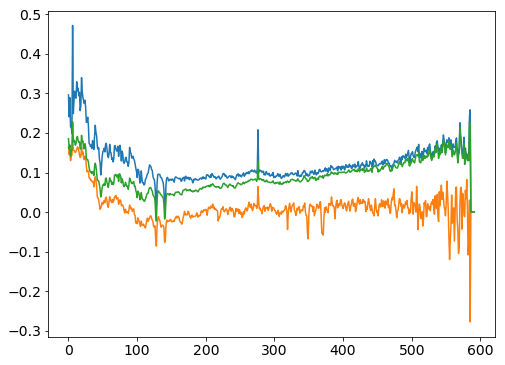

In [51]:
plt.plot(delta['delta_mean'].value)
plt.plot(delta['delta_mean_ivar_weighted'].value)
plt.plot(delta['delta_mean_weighted'].value)

### Lines Of Sight

In [52]:
lines_of_sight = delta['lines_of_sight']

In [53]:
lines_of_sight.name

u'/lines_of_sight'

In [54]:
%%time
los_keys = lines_of_sight.keys()

CPU times: user 586 ms, sys: 528 ms, total: 1.11 s
Wall time: 2.94 s


In [55]:
lines_of_sight[los_keys[0]].keys()

[u'delta', u'ivar', u'loglam', u'r_comov', u'weight']

In [56]:
lines_of_sight[los_keys[0]].attrs.keys()

[u'plate', u'mjd', u'fiber', u'ra', u'dec', u'z', u'p0', u'p1']

In [57]:
z = lines_of_sight[los_keys[0]].attrs['z']
z

2.2844033241271973

In [58]:
unmasked_pixels = lines_of_sight[los_keys[0]]['weight'].value > 0

### Universal wavelength grid

In [59]:
loglam = lines_of_sight[los_keys[0]]['loglam'].value[unmasked_pixels]
lambdas = 10**(loglam)/(1 + z)

In [60]:
deltas = lines_of_sight[los_keys[0]]['delta'].value[unmasked_pixels]
weights = lines_of_sight[los_keys[0]]['weight'].value[unmasked_pixels]

### test outer product and log transforms

In [61]:
np.allclose(10**np.subtract.outer(loglam, loglam), np.divide.outer(lambdas, lambdas))

True

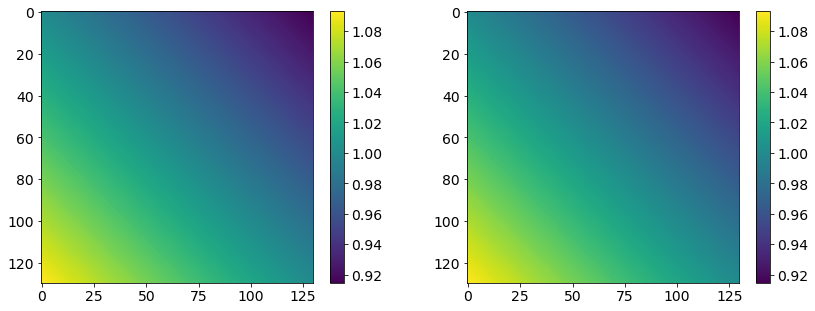

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

cax = ax1.imshow(np.divide.outer(lambdas, lambdas), interpolation='none')
fig.colorbar(cax, ax=ax1)

cax = ax2.imshow(10**np.subtract.outer(loglam, loglam), interpolation='none')
fig.colorbar(cax, ax=ax2)

plt.show()

In [63]:
unique_pair_mask = np.divide.outer(lambdas, lambdas) > 1

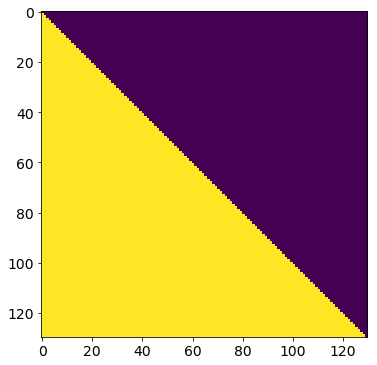

In [64]:
plt.imshow(unique_pair_mask)
plt.show()

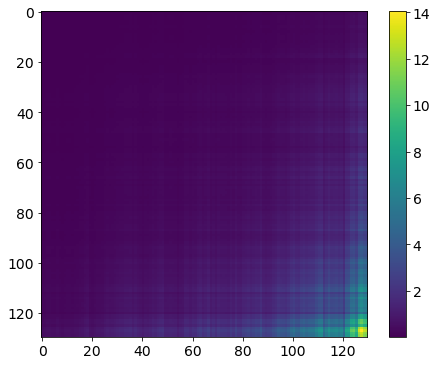

In [65]:
plt.imshow(np.multiply.outer(weights, weights), interpolation='none')
plt.colorbar()
plt.show()

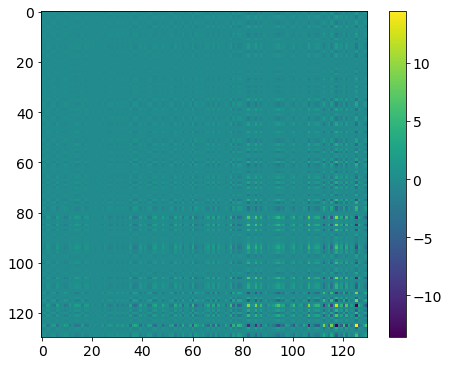

In [66]:
plt.imshow(np.multiply.outer(weights*deltas, weights*deltas), interpolation='none')
plt.colorbar()
plt.show()

In [67]:
np.sum(np.multiply.outer(weights*deltas, weights*deltas)[unique_pair_mask])

49.974780345588343

In [68]:
xi_bins_edges = np.linspace(1, 1.07, 51)

In [69]:
np.allclose(xi_bins_edges[1:] - xi_bins_edges[:-1], (xi_bins_edges[1:] - xi_bins_edges[:-1])[0])

True

In [98]:
%%time
unique_lambda_ratios = set()

for i, forest_id in enumerate(los_keys[::1000]):
    los = lines_of_sight[forest_id]
    unmasked_pixels = los['weight'].value > 0
    loglam = los['loglam'].value[unmasked_pixels]

    lambda_ratios = np.around(10**np.subtract.outer(loglam, loglam), 4)
    unique_pair_mask = (lambda_ratios > 1.00) & (lambda_ratios < 1.07)
    
    unique_lambda_ratios.update(set(lambda_ratios[unique_pair_mask]))

lambda_ratio_values = np.array(sorted(list(unique_lambda_ratios)))

CPU times: user 510 ms, sys: 12.6 ms, total: 522 ms
Wall time: 530 ms


In [99]:
len(lambda_ratio_values)

97

In [100]:
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [102]:
%%time

weighted_delta_product_sum = np.zeros(len(lambda_ratio_values))
weighted_delta_product_sumsq = np.zeros(len(lambda_ratio_values))
weighted_product_sum = np.zeros(len(lambda_ratio_values))
product_count = np.zeros(len(lambda_ratio_values))

for i, forest_id in tqdm_notebook(enumerate(los_keys), total=len(los_keys)):
    los = lines_of_sight[forest_id]
    unmasked_pixels = los['weight'].value > 0
    loglam = los['loglam'].value[unmasked_pixels]
    deltas = los['delta'].value[unmasked_pixels]
    weights = los['weight'].value[unmasked_pixels]
    
    lambda_ratios = np.around(10**np.subtract.outer(loglam, loglam), 4)   
    unique_pair_mask = (lambda_ratios > 1.00) & (lambda_ratios < 1.07)
    
    unique_lambda_ratios.update(set(lambda_ratios[unique_pair_mask]))

    weighted_delta_product = np.multiply.outer(weights*deltas, weights*deltas)
    weighted_product = np.multiply.outer(weights, weights)
            
    indices = lambda_ratio_values.searchsorted(lambda_ratios[unique_pair_mask])
    
    weighted_delta_product_sum += np.bincount(
        indices, 
        weights=weighted_delta_product[unique_pair_mask], 
        minlength=len(lambda_ratio_values)
    )
    
    weighted_delta_product_sumsq += np.bincount(
        indices, 
        weights=weighted_delta_product[unique_pair_mask]**2, 
        minlength=len(lambda_ratio_values)
    )
    
    weighted_product_sum += np.bincount(
        indices, 
        weights=weighted_product[unique_pair_mask], 
        minlength=len(lambda_ratio_values)
    )
    
    product_count += np.bincount(
        indices, 
        minlength=len(lambda_ratio_values)
    )


CPU times: user 11min 17s, sys: 16.6 s, total: 11min 34s
Wall time: 11min 40s


In [254]:
## https://physics.nist.gov/PhysRefData/ASD/lines_form.html
lines = {
    'LyA'   : 121.6,
    'SiIIa' : 119.0416,
    'SiIIb' : 119.3290,
    'SiIIc' : 126.0422,
    'SiIII' : 120.6500,
}

In [255]:
line_wavelengths = [v for k,v in lines.iteritems()]
line_ratios = np.divide.outer(line_wavelengths, line_wavelengths)

In [256]:
line_ratios[line_ratios > 1]

array([ 1.05625791,  1.05880801,  1.03653125,  1.04469291,  1.00241428,
        1.01903142,  1.02149165,  1.00787402,  1.01107023,  1.01351124])

(1.0562579088067443, 'SiIIc/SiIIb')
(1.0190314173419706, 'LyA/SiIIb')
(1.0110702343939866, 'SiIII/SiIIb')
(1.058808013333154, 'SiIIc/SiIIa')
(1.0024142820661013, 'SiIIb/SiIIa')
(1.021491646617653, 'LyA/SiIIa')
(1.0135112431284525, 'SiIII/SiIIa')
(1.03653125, 'SiIIc/LyA')
(1.0446929133858267, 'SiIIc/SiIII')
(1.0078740157480315, 'LyA/SiIII')


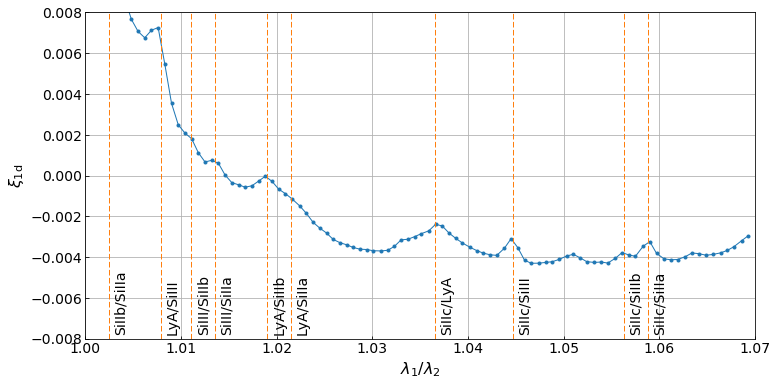

In [257]:
fig, ax = plt.subplots(figsize=(12, 6))

xi_1d = weighted_delta_product_sum/weighted_product_sum

ymin, ymax = -0.008, 0.008

plt.plot(lambda_ratio_values, xi_1d, marker='.', lw=1)

for k1, v1 in lines.iteritems():
    for k2, v2 in lines.iteritems():
        line_ratio = v2 / v1
        if line_ratio > 1 and line_ratio < 1.07:
            print(v2 / v1, '{}/{}'.format(k2, k1))
            plt.axvline(line_ratio, ls='--', color='#ff7f0e', lw=1)
            ax.text(line_ratio + 0.0005, ymin + 0.0002, '{}/{}'.format(k2, k1), 
                    rotation='vertical',
                    horizontalalignment='left',
                    verticalalignment='bottom',
                   )
            
plt.ylim(ymin, ymax)
plt.xlim(1, 1.07)
plt.xlabel(r'$\lambda_1 / \lambda_2$', fontsize=16)
plt.ylabel(r'$\xi_\mathrm{1d}$', fontsize=16)
plt.grid()

In [178]:
#lambda_ratio_values = np.array(sorted(list(unique_lambda_ratios)))

In [179]:
line_ratios

array([[ 1.        ,  1.05625791,  1.05880801,  1.03681262,  1.04469291],
       [ 0.94673847,  1.        ,  1.00241428,  0.9815904 ,  0.98905097],
       [ 0.94445828,  0.99759153,  1.        ,  0.97922627,  0.98666888],
       [ 0.96449443,  1.01875487,  1.02121443,  1.        ,  1.0076005 ],
       [ 0.95721909,  1.01107023,  1.01351124,  0.99245683,  1.        ]])

In [180]:
lambda_ratio_values == lambda_ratios[unique_pair_mask]

False

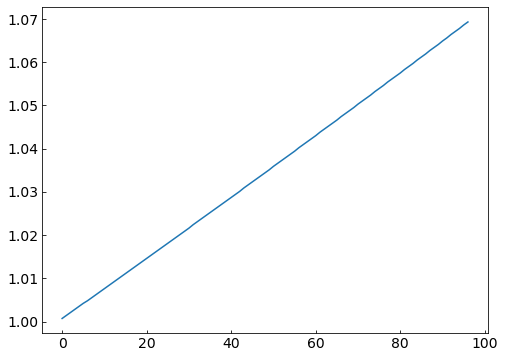

In [181]:
plt.plot(sorted(list(unique_lambda_ratios)))
plt.show()

### Compare with mock

In [115]:
name = 'mock-000'
mock_delta = h5py.File('{}/{}-delta.hdf5'.format(name, name), mode='r')
mock_lines_of_sight = mock_delta['lines_of_sight']

In [136]:
%%time
unique_lambda_ratios = set()

for i, forest_id in enumerate(mock_lines_of_sight.keys()[::1000]):
    los = mock_lines_of_sight[forest_id]
    unmasked_pixels = los['weight'].value > 0
    loglam = los['loglam'].value[unmasked_pixels]

    lambda_ratios = np.around(10**np.subtract.outer(loglam, loglam), 4)
    unique_pair_mask = (lambda_ratios > 1.00) & (lambda_ratios < 1.07)
    
    unique_lambda_ratios.update(set(lambda_ratios[unique_pair_mask]))

lambda_ratio_values = np.array(sorted(list(unique_lambda_ratios)))

CPU times: user 687 ms, sys: 52.8 ms, total: 740 ms
Wall time: 710 ms


In [137]:
len(unique_lambda_ratios)

97

In [142]:
def compute_los_xi(lines_of_sight, lambda_ratio_values):
    
    nbins = len(lambda_ratio_values)
    nlos = len(lines_of_sight)

    weighted_delta_product_sum = np.zeros(nbins)
    weighted_delta_product_sumsq = np.zeros(nbins)
    weighted_product_sum = np.zeros(nbins)
    product_count = np.zeros(nbins)

    for forest_id, los in tqdm_notebook(lines_of_sight.iteritems(), total=nlos):
        unmasked_pixels = los['weight'].value > 0
        loglam = los['loglam'].value[unmasked_pixels]
        deltas = los['delta'].value[unmasked_pixels]
        weights = los['weight'].value[unmasked_pixels]

        lambda_ratios = np.around(10**np.subtract.outer(loglam, loglam), 4)   
        unique_pair_mask = (lambda_ratios > 1.00) & (lambda_ratios < 1.07)

        weighted_delta_product = np.multiply.outer(weights*deltas, weights*deltas)
        weighted_product = np.multiply.outer(weights, weights)

        indices = lambda_ratio_values.searchsorted(lambda_ratios[unique_pair_mask])

        weighted_delta_product_sum += np.bincount(
            indices, 
            weights=weighted_delta_product[unique_pair_mask], 
            minlength=nbins
        )

        weighted_delta_product_sumsq += np.bincount(
            indices, 
            weights=weighted_delta_product[unique_pair_mask]**2/weighted_product, 
            minlength=nbins
        )

        weighted_product_sum += np.bincount(
            indices, 
            weights=weighted_product[unique_pair_mask], 
            minlength=nbins
        )

        product_count += np.bincount(
            indices, 
            minlength=nbins
        )
        
    xi = weighted_delta_product_sum/weighted_product_sum
    xi_var = weighted_delta_product_sumsq/weighted_product_sum - xi*xi
        
    return xi, xi_var

In [143]:
mock_los_xi, mock_los_xi_var = compute_los_xi(mock_lines_of_sight, lambda_ratio_values)

In [162]:
dr12_los_xi, dr12_los_xi_var = compute_los_xi(lines_of_sight, lambda_ratio_values)

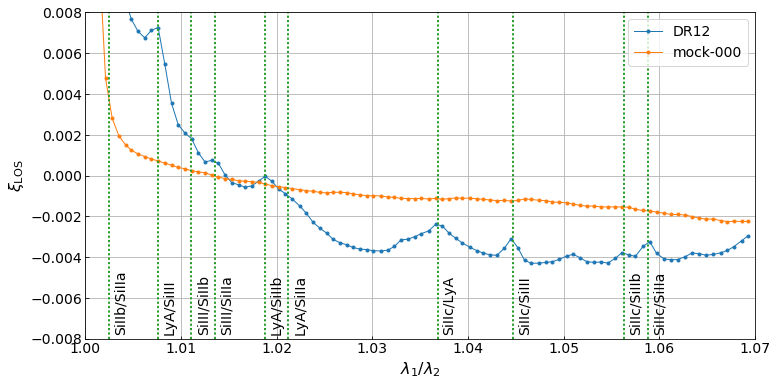

In [217]:
fig, ax = plt.subplots(figsize=(12, 6))

ymin, ymax = -0.008, 0.008

plt.plot(lambda_ratio_values, xi_1d, marker='.', lw=1, label='DR12')
plt.plot(lambda_ratio_values, mock_los_xi, marker='.', lw=1, label='mock-000')

for k1, v1 in lines.iteritems():
    for k2, v2 in lines.iteritems():
        line_ratio = v2 / v1
        if line_ratio > 1:
            plt.axvline(line_ratio, ls=':', color='C2', lw=2)
            ax.text(line_ratio + 0.0005, ymin + 0.0002, '{}/{}'.format(k2, k1), 
                    rotation='vertical',
                    horizontalalignment='left',
                    verticalalignment='bottom',
                   )
            
plt.ylim(ymin, ymax)
plt.xlim(1, 1.07)
plt.xlabel(r'$\lambda_1 / \lambda_2$', fontsize=16)
plt.ylabel(r'$\xi_\mathrm{LOS}$', fontsize=16)
plt.legend()
plt.grid()
plt.savefig('xi_los.png', dpi=100, bbox_inches='tight')

In [213]:
np.log10(lambda_ratio_values)

array([ 0.0003039 ,  0.00060758,  0.00091106,  0.00121432,  0.00151737,
        0.00182021,  0.00207961,  0.00238206,  0.00268429,  0.00298632,
        0.00328814,  0.00358974,  0.00389114,  0.00419233,  0.00449336,
        0.00479413,  0.0050947 ,  0.00539505,  0.0056952 ,  0.00599514,
        0.00629487,  0.0065944 ,  0.00689372,  0.00719284,  0.00749174,
        0.00779045,  0.00808894,  0.00838724,  0.00868533,  0.00898321,
        0.00928089,  0.00962085,  0.00991809,  0.01021513,  0.01051197,
        0.0108086 ,  0.01110503,  0.01140126,  0.01169729,  0.01199311,
        0.01228874,  0.01258416,  0.01287938,  0.01321654,  0.01351133,
        0.01380593,  0.01410032,  0.01439451,  0.01468851,  0.0149823 ,
        0.01531783,  0.0156112 ,  0.01590437,  0.01619735,  0.01649013,
        0.0167827 ,  0.01711685,  0.017409  ,  0.01770097,  0.01799273,
        0.0182843 ,  0.01861729,  0.01890844,  0.0191994 ,  0.01949016,
        0.01978072,  0.02011257,  0.02040272,  0.02069267,  0.02

In [261]:
%%time
unique_lambda_products = set()

for i, forest_id in enumerate(los_keys[::1000]):
    los = lines_of_sight[forest_id]
    unmasked_pixels = los['weight'].value > 0
    loglam = los['loglam'].value[unmasked_pixels]

    lambda_products = np.around(10**(0.5*np.add.outer(loglam, loglam))/1216.0, 2) - 1
    unique_pair_mask = (lambda_products > 1) & (lambda_products < 4)
    unique_lambda_products.update(set(lambda_products[unique_pair_mask]))

lambda_product_values = np.array(sorted(list(unique_lambda_products)))

CPU times: user 830 ms, sys: 8 ms, total: 838 ms
Wall time: 838 ms


In [262]:
len(lambda_product_values)

137

In [292]:
def compute_los_xi_z(lines_of_sight, lambda_product_values):
    
    nbins = len(lambda_product_values)
    nlos = len(lines_of_sight)
    
    min_bin = min(lambda_product_values)
    max_bin = max(lambda_product_values)

    weighted_delta_product_sum = np.zeros(nbins)
    weighted_product_sum = np.zeros(nbins)
    product_count = np.zeros(nbins)
    
    for forest_id, los in tqdm_notebook(lines_of_sight.iteritems(), total=nlos):
        unmasked_pixels = los['weight'].value > 0
        loglam = los['loglam'].value[unmasked_pixels]
        deltas = los['delta'].value[unmasked_pixels]
        weights = los['weight'].value[unmasked_pixels]

        lambda_products = np.around(10**(0.5*np.add.outer(loglam, loglam))/1216.0, 2) - 1
        unique_pair_mask = (lambda_products >= min_bin) & (lambda_products < max_bin)
        unique_lambda_products.update(set(lambda_products[unique_pair_mask]))

        weighted_delta_product = np.multiply.outer(weights*deltas, weights*deltas)
        weighted_product = np.multiply.outer(weights, weights)

        indices = lambda_product_values.searchsorted(lambda_products[unique_pair_mask])

        weighted_delta_product_sum += np.bincount(
            indices, 
            weights=weighted_delta_product[unique_pair_mask], 
            minlength=nbins
        )

        weighted_product_sum += np.bincount(
            indices, 
            weights=weighted_product[unique_pair_mask], 
            minlength=nbins
        )

        product_count += np.bincount(
            indices, 
            minlength=nbins
        )
        
    xi = weighted_delta_product_sum/weighted_product_sum
        
    return xi, product_count

In [293]:
mock_los_xi_z, mock_los_xi_z_count = compute_los_xi_z(mock_lines_of_sight, lambda_product_values)

In [294]:
dr12_los_xi_z, dr12_los_xi_z_count = compute_los_xi_z(lines_of_sight, lambda_product_values)

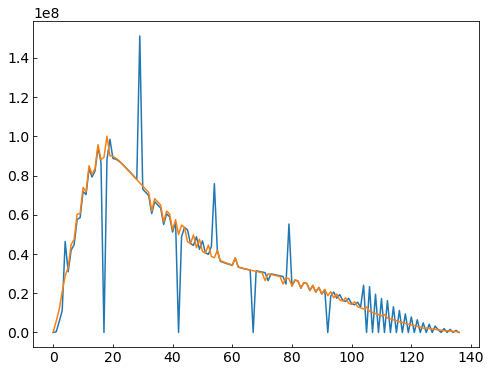

In [310]:
plt.plot(mock_los_xi_z_count)
plt.plot(dr12_los_xi_z_count)

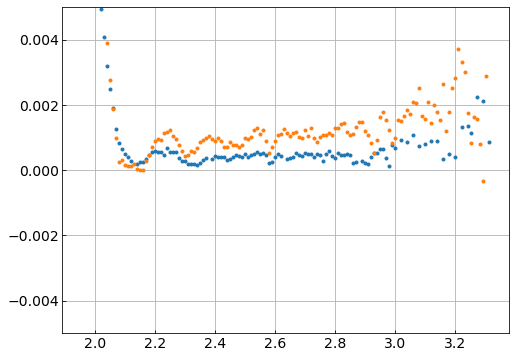

In [316]:
plt.plot(lambda_product_values, mock_los_xi_z, marker='.', lw=0)
plt.plot(lambda_product_values, dr12_los_xi_z, marker='.', lw=0)

ylim = 0.005
plt.ylim(-ylim, ylim)
plt.grid()